## Load and Prepare Linearly Separable Data


In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_linear, y_linear = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, flip_y=0, random_state=42)
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

## Implement Perceptron Model


In [2]:
import numpy as np

class LinearNeuron:
    def __init__(self, lr=0.01, epochs=100):
        self.lr = lr
        self.epochs = epochs
        self.W = None
        self.b = None

    def _step_function(self, x):
        return np.where(x >= 0, 1, 0)

    def train(self, X, y):
        n_samples, n_features = X.shape

        self.W = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            for idx, x_sample in enumerate(X):
                linear_output = np.dot(x_sample, self.W) + self.b
                y_forwarded = self._step_function(linear_output)
                error = y[idx] - y_forwarded

                self.W += self.lr * error * x_sample
                self.b += self.lr * error

    def forward(self, X):
        linear_output = np.dot(X, self.W) + self.b
        y_forwarded = self._step_function(linear_output)
        return y_forwarded

## Train and Evaluate Perceptron

In [3]:
from sklearn.metrics import accuracy_score

perceptron_model = LinearNeuron(lr=0.01, epochs=100)
perceptron_model.train(X_linear_train, y_linear_train)

y_linear_pred = perceptron_model.forward(X_linear_test)

accuracy = accuracy_score(y_linear_test, y_linear_pred)
print(f"LinearNeuron Model Accuracy on linearly separable test data: {accuracy:.4f}")

LinearNeuron Model Accuracy on linearly separable test data: 0.9755


## Visualize Perceptron Decision Boundary


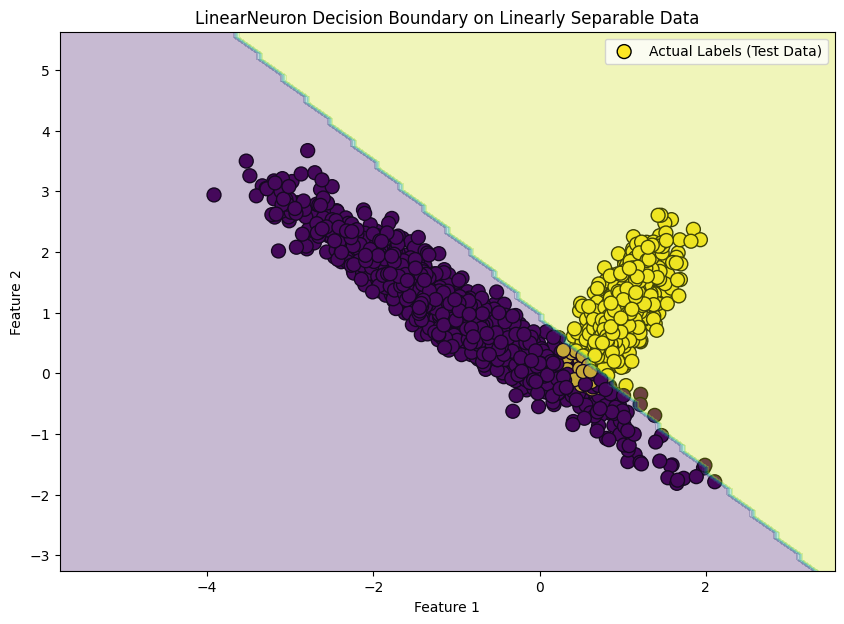

LinearNeuron decision boundary visualized successfully.


In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(X_linear_test[:, 0], X_linear_test[:, 1], c=y_linear_test, cmap='viridis', s=100, edgecolors='k', marker='o', label='Actual Labels (Test Data)')

x_min, x_max = X_linear[:, 0].min() - 1, X_linear[:, 0].max() + 1
y_min, y_max = X_linear[:, 1].min() - 1, X_linear[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

Z = perceptron_model.forward(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.title('LinearNeuron Decision Boundary on Linearly Separable Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend()
plt.show()
print("LinearNeuron decision boundary visualized successfully.")

## Load and Prepare Non-Linearly Separable Data


In [6]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_nonlinear, y_nonlinear = make_moons(n_samples=10000, noise=0.1, random_state=42)

X_nonlinear_train, X_nonlinear_test, y_nonlinear_train, y_nonlinear_test = train_test_split(
    X_nonlinear, y_nonlinear, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_nonlinear_train = scaler.fit_transform(X_nonlinear_train)
X_nonlinear_test = scaler.transform(X_nonlinear_test)

## Implement Multi-layer Neural Network


In [7]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_sizes, lr=0.01, epochs=1000):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.epochs = epochs
        self.W = {}
        self.bes = {}
        self._initialize_parameters()

    def _initialize_parameters(self):
        np.random.seed(42)
        for i in range(1, len(self.layer_sizes)):
            scale = np.sqrt(2.0 / self.layer_sizes[i-1])

            self.W[f'W{i}'] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * scale
            self.bes[f'b{i}'] = np.zeros((1, self.layer_sizes[i]))

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        s = self._sigmoid(x)
        return s * (1 - s)

    def _forward_pass(self, X):
        activations = {'A0': X}
        pre_activations = {}

        num_layers = len(self.layer_sizes) - 1

        for i in range(1, num_layers + 1):
            Z = np.dot(activations[f'A{i-1}'], self.W[f'W{i}']) + self.bes[f'b{i}']
            pre_activations[f'Z{i}'] = Z

            if i < num_layers:
                A = self._relu(Z)
            else:
                A = self._sigmoid(Z)
            activations[f'A{i}'] = A

        return activations, pre_activations

    def _compute_loss(self, y_true, y_pred):
        epsilon = 1e-10
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def _backward_pass(self, X, y_true, y_pred, activations, pre_activations):
        grads = {}
        num_layers = len(self.layer_sizes) - 1

        y_true = y_true.reshape(-1, 1)
        dZ = y_pred - y_true

        grads[f'dW{num_layers}'] = np.dot(activations[f'A{num_layers-1}'].T, dZ)
        grads[f'db{num_layers}'] = np.sum(dZ, axis=0, keepdims=True)

        for i in range(num_layers - 1, 0, -1):
            dZ = np.dot(dZ, self.W[f'W{i+1}'].T) * self._relu_derivative(pre_activations[f'Z{i}'])
            grads[f'dW{i}'] = np.dot(activations[f'A{i-1}'].T, dZ)
            grads[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True)

        n_samples = X.shape[0]
        for key in grads:
            grads[key] /= n_samples

        return grads

    def _update_W(self, grads):
        for i in range(1, len(self.layer_sizes)):
            self.W[f'W{i}'] -= self.lr * grads[f'dW{i}']
            self.bes[f'b{i}'] -= self.lr * grads[f'db{i}']

    def train(self, X, y):
        for epoch in range(self.epochs):
            activations, pre_activations = self._forward_pass(X)
            y_pred = activations[f'A{len(self.layer_sizes)-1}']
            loss = self._compute_loss(y, y_pred)

            grads = self._backward_pass(X, y, y_pred, activations, pre_activations)
            self._update_W(grads)

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def forward(self, X):
        activations, _ = self._forward_pass(X)
        output_activation = activations[f'A{len(self.layer_sizes)-1}']
        return (output_activation >= 0.5).astype(int).flatten()

## Train and Evaluate MLNN


In [8]:
from sklearn.metrics import accuracy_score

input_features = X_nonlinear_train.shape[1]
layer_sizes = [input_features, 10, 1]

mlnn_model = NeuralNetwork(layer_sizes=layer_sizes, lr=0.01, epochs=5000)

print(f"SimpleMLP model initialized with layer sizes: {layer_sizes}")
print(f"Training SimpleMLP model with lr={mlnn_model.lr} and epochs={mlnn_model.epochs}.")

y_nonlinear_train_reshaped = y_nonlinear_train.reshape(-1, 1)
mlnn_model.train(X_nonlinear_train, y_nonlinear_train_reshaped)

y_nonlinear_pred = mlnn_model.forward(X_nonlinear_test)
accuracy_mlnn = accuracy_score(y_nonlinear_test, y_nonlinear_pred)

print(f"\nSimpleMLP Model Accuracy on non-linearly separable test data: {accuracy_mlnn:.4f}")

SimpleMLP model initialized with layer sizes: [2, 10, 1]
Training SimpleMLP model with lr=0.01 and epochs=5000.
Epoch 100/5000, Loss: 0.5418
Epoch 200/5000, Loss: 0.4783
Epoch 300/5000, Loss: 0.4442
Epoch 400/5000, Loss: 0.4190
Epoch 500/5000, Loss: 0.3994
Epoch 600/5000, Loss: 0.3838
Epoch 700/5000, Loss: 0.3712
Epoch 800/5000, Loss: 0.3608
Epoch 900/5000, Loss: 0.3523
Epoch 1000/5000, Loss: 0.3450
Epoch 1100/5000, Loss: 0.3389
Epoch 1200/5000, Loss: 0.3337
Epoch 1300/5000, Loss: 0.3291
Epoch 1400/5000, Loss: 0.3251
Epoch 1500/5000, Loss: 0.3216
Epoch 1600/5000, Loss: 0.3184
Epoch 1700/5000, Loss: 0.3156
Epoch 1800/5000, Loss: 0.3131
Epoch 1900/5000, Loss: 0.3108
Epoch 2000/5000, Loss: 0.3087
Epoch 2100/5000, Loss: 0.3067
Epoch 2200/5000, Loss: 0.3049
Epoch 2300/5000, Loss: 0.3032
Epoch 2400/5000, Loss: 0.3015
Epoch 2500/5000, Loss: 0.2999
Epoch 2600/5000, Loss: 0.2984
Epoch 2700/5000, Loss: 0.2969
Epoch 2800/5000, Loss: 0.2954
Epoch 2900/5000, Loss: 0.2939
Epoch 3000/5000, Loss: 0.29

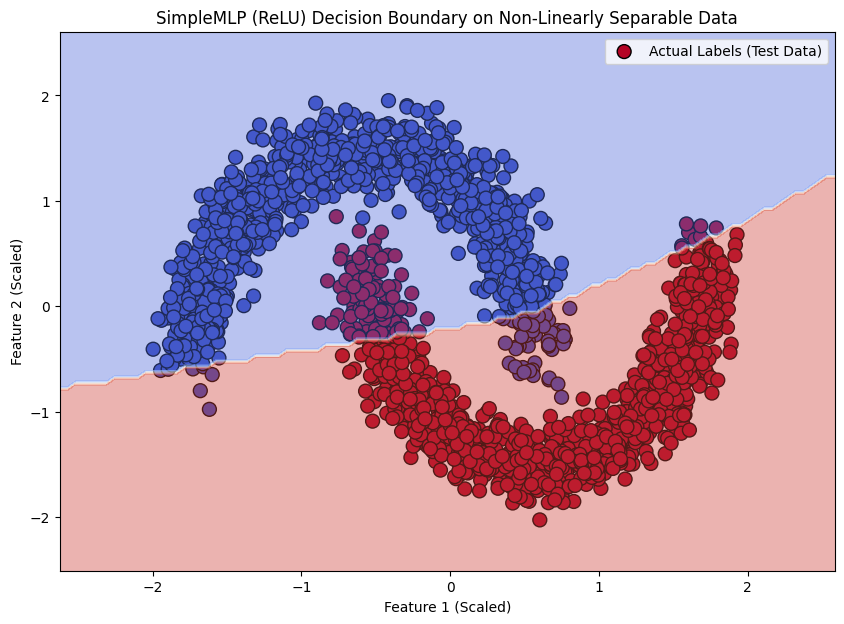

SimpleMLP decision boundary visualized successfully.


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(X_nonlinear_test[:, 0], X_nonlinear_test[:, 1], c=y_nonlinear_test, cmap='coolwarm', s=100, edgecolors='k', marker='o', label='Actual Labels (Test Data)')

x_min, x_max = X_nonlinear[:, 0].min() - 0.5, X_nonlinear[:, 0].max() + 0.5
y_min, y_max = X_nonlinear[:, 1].min() - 0.5, X_nonlinear[:, 1].max() + 0.5

scaled_x_min, scaled_x_max = X_nonlinear_train[:, 0].min() - 0.5, X_nonlinear_train[:, 0].max() + 0.5
scaled_y_min, scaled_y_max = X_nonlinear_train[:, 1].min() - 0.5, X_nonlinear_train[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.linspace(scaled_x_min, scaled_x_max, 100), np.linspace(scaled_y_min, scaled_y_max, 100))

Z_grid_input = np.c_[xx.ravel(), yy.ravel()]
Z = mlnn_model.forward(Z_grid_input)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
plt.title('SimpleMLP (ReLU) Decision Boundary on Non-Linearly Separable Data')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend()
plt.show()
print("SimpleMLP decision boundary visualized successfully.")